O serviço de vendas de carros usados Rusty Bargain está desenvolvendo um aplicativo para atrair novos clientes. Nesse aplicativo, você pode descobrir rapidamente o valor de mercado do seu carro. Você tem acesso a dados históricos: especificações técnicas, versões de acabamento e preços. Você precisa construir o modelo para determinar o valor. 

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

## Preparação de Dados

Primeiro passo será importar as bibliotecas necessárias.

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from IPython.display import display

import matplotlib.pyplot as plt

Carreguei os dados:

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

Mostrando as 10 primeiras linhas do dataframe:

In [3]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
38943,19/03/2016 17:46,2650,small,2004,manual,83,jazz,125000,2,petrol,honda,no,19/03/2016 00:00,0,99947,21/03/2016 23:18
78637,04/04/2016 00:46,2500,sedan,1994,manual,150,5er,150000,10,petrol,bmw,no,03/04/2016 00:00,0,76351,06/04/2016 07:16
315110,10/03/2016 19:36,850,small,2001,manual,58,agila,125000,9,petrol,opel,no,10/03/2016 00:00,0,42799,10/03/2016 19:36
269734,25/03/2016 11:40,2300,sedan,2002,manual,122,vectra,150000,3,petrol,opel,no,25/03/2016 00:00,0,53840,31/03/2016 18:15
262459,10/03/2016 16:06,1850,sedan,1999,NaN,0,3er,150000,3,petrol,bmw,no,10/03/2016 00:00,0,35614,06/04/2016 10:17
138886,22/03/2016 17:57,150,NaN,2000,manual,115,golf,150000,8,gasoline,volkswagen,NaN,22/03/2016 00:00,0,95339,22/03/2016 17:57
213945,29/03/2016 10:59,9999,coupe,1973,auto,185,other,150000,9,petrol,mercedes_benz,no,29/03/2016 00:00,0,88048,05/04/2016 19:46
205392,13/03/2016 17:48,16500,wagon,2010,manual,143,3er,125000,3,gasoline,bmw,no,13/03/2016 00:00,0,90552,06/04/2016 17:46
118381,20/03/2016 09:51,2650,small,2002,auto,54,fortwo,80000,10,petrol,smart,no,20/03/2016 00:00,0,48432,23/03/2016 23:45
297349,14/03/2016 22:50,4499,sedan,2002,manual,122,vectra,150000,6,lpg,opel,no,14/03/2016 00:00,0,46499,15/03/2016 19:15


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Aqui percebi que existem  valores ausentes e as colunas data não estão no formato data correto. As outras variáveis estão nos formatos corretos. Posteriormente, farei o pré-processamento de dados para lidar com essas questões.  

In [5]:
df.isna().mean()*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Transformando as colunas data:

In [6]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'],format = '%d/%m/%Y %H:%M') 
df['DateCreated'] = pd.to_datetime(df['DateCreated'],format = '%d/%m/%Y %H:%M') 
df['LastSeen'] = pd.to_datetime(df['LastSeen'],format = '%d/%m/%Y %H:%M') 


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Estudando o balanceamento  de classes:

In [8]:
colunas_estudo = ['VehicleType', 'Gearbox','Model','FuelType', 'Brand','NotRepaired']
colunas_estudo
for i in colunas_estudo:
    print('Value Counts:',i)
    print(df.value_counts(i)/df.shape[0]*100)
    print()

Value Counts: VehicleType
VehicleType
sedan          25.808409
small          22.527648
wagon          18.389306
bus             8.120067
convertible     5.701119
coupe           4.561065
suv             3.385172
other           0.927846
dtype: float64

Value Counts: Gearbox
Gearbox
manual    75.698213
auto      18.705079
dtype: float64

Value Counts: Model
Model
golf                  8.249029
other                 6.891404
3er                   5.576391
polo                  3.687117
corsa                 3.547150
                        ...   
serie_2               0.002258
serie_3               0.001129
rangerover            0.001129
range_rover_evoque    0.000564
serie_1               0.000564
Length: 250, dtype: float64

Value Counts: FuelType
FuelType
petrol      61.052744
gasoline    27.857967
lpg          1.498438
cng          0.159438
hybrid       0.065751
other        0.057567
electric     0.025397
dtype: float64

Value Counts: Brand
Brand
volkswagen        21.732431
opel    

Percebi que a coluna com número de fotos do veículo está toda desajustada. Portanto, decidi excluí-la. 

In [9]:
df.drop('NumberOfPictures', axis=1, inplace=True)

Substitui todos os valores ausentes da coluna 'NotRepaired' por ‘no’. Após, alterei todos os valores 'no' por 0 e 'yes' por 1. Assim, poderei usar essa coluna nos modelos posteriores de regressão. 

In [10]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')
df['NotRepaired'] = np.where(df['NotRepaired']=='no', 0, 1)
df['NotRepaired'].value_counts()/len(df['NotRepaired'])

0    0.898259
1    0.101741
Name: NotRepaired, dtype: float64

Verifiquei que ‘petrol’ e ‘gasoline’ referem-se ao mesmo tipo de combustível. Logo todos esses valores serão considerados como ‘gasoline’. 

In [11]:
df.loc[df['FuelType'] =='petrol','FuelType'] = 'gasoline'

Como é muito difícil fazer qualquer previsão sobre o modelo. Resolvi substituir todos os valores ausentes da coluna por 'other' que era uma coluna que já existia no dataframe. 

In [12]:
df['Model'] = df['Model'].fillna('other')

In [13]:
df['Model'].value_counts()

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

Para converter os valores ausentes das colunas: tipo de veículo, tipo de caixa de transmissão e tipo de combustível, escolhi o valor mais comum em relação ao modelo. 

In [14]:
tabela_VehicleType = df.groupby('Model')['VehicleType'].apply(lambda x: x.mode()[0])
tabela_Gearbox = df.groupby('Model')['Gearbox'].apply(lambda x: x.mode()[0])
tabela_FuelType = df.groupby('Model')['FuelType'].apply(lambda x: x.mode()[0])
tabela = pd.concat([tabela_VehicleType,tabela_Gearbox,tabela_FuelType], axis=1)
tabela = tabela.reset_index()
tabela

,Model,VehicleType,Gearbox,FuelType
0,100,sedan,manual,gasoline
1,145,small,manual,gasoline
2,147,sedan,manual,gasoline
3,156,wagon,manual,gasoline
4,159,wagon,manual,gasoline
...,...,...,...,...
245,yaris,small,manual,gasoline
246,yeti,suv,manual,gasoline
247,ypsilon,small,manual,gasoline
248,z_reihe,convertible,manual,gasoline


In [15]:
merge_df=df.merge(tabela,on='Model',how='left')
merge_df

,DateCrawled,Price,VehicleType_x,RegistrationYear,Gearbox_x,Power,Model,Mileage,RegistrationMonth,FuelType_x,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,VehicleType_y,Gearbox_y,FuelType_y
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,gasoline,volkswagen,0,2016-03-24,70435,2016-04-07 03:16:00,sedan,manual,gasoline
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,1,2016-03-24,66954,2016-04-07 01:46:00,sedan,manual,gasoline
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0,2016-03-14,90480,2016-04-05 12:47:00,suv,auto,gasoline
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,0,2016-03-17,91074,2016-03-17 17:40:00,sedan,manual,gasoline
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,2016-03-31,60437,2016-04-06 10:17:00,small,manual,gasoline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:00,0,NaN,2005,manual,0,colt,150000,7,gasoline,mitsubishi,1,2016-03-21,2694,2016-03-21 10:42:00,sedan,manual,gasoline
354365,2016-03-14 17:48:00,2200,NaN,2005,NaN,0,other,20000,1,NaN,sonstige_autos,0,2016-03-14,39576,2016-04-06 00:46:00,sedan,manual,gasoline
354366,2016-03-05 19:56:00,1199,convertible,2000,auto,101,fortwo,125000,3,gasoline,smart,0,2016-03-05,26135,2016-03-11 18:17:00,small,auto,gasoline
354367,2016-03-19 18:57:00,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0,2016-03-19,87439,2016-04-07 07:15:00,bus,manual,gasoline


In [16]:
def preencher_Gearbox_x(row): 
    Gearbox_x = row['Gearbox_x']
    Gearbox_y = row['Gearbox_y']

    if pd.isna(Gearbox_x):
        return Gearbox_y  
    else:
        return Gearbox_x 

In [17]:
def preencher_VehicleType_x(row): 
    VehicleType_x = row['VehicleType_x']
    VehicleType_y = row['VehicleType_y']

    if pd.isna(VehicleType_x):
        return VehicleType_y  
    else:
        return VehicleType_x 

In [18]:
def FuelType_x(row): 
    FuelType_x = row['FuelType_x']
    FuelType_y = row['FuelType_y']

    if pd.isna(FuelType_x):
        return FuelType_y  
    else:
        return FuelType_x 

In [19]:

merge_df['Gearbox_x'] = merge_df.apply(preencher_Gearbox_x, axis=1)

In [20]:
merge_df['VehicleType_x'] = merge_df.apply(preencher_VehicleType_x, axis=1)

In [21]:
merge_df['FuelType_x'] = merge_df.apply(FuelType_x, axis=1)

In [22]:

merge_df['FuelType_x'] = merge_df.apply(FuelType_x, axis=1)


Conferi que não existem  mais valores nulos na tabela:

In [23]:
df = merge_df
df=df.rename(columns={'DateCrawled':'date_crawled','Price':'price','RegistrationYear':'registration_year','Power':'power',"Model":'model','Mileage':'mileage','RegistrationMonth':'registration_month','Brand':'brand','NotRepaired':'not_repaired','DateCreated':'date_created','PostalCode':'postal_code','LastSeen':'last_seen' ,'Gearbox_x':'gearbox','VehicleType_x':'vehicle_type','FuelType_x':'fuel_type'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        354369 non-null  int64         
 12  date_created        354369 non-null  datetime64[ns]
 13  postal_code         354369 no

In [24]:
df.drop(['VehicleType_y','Gearbox_y','FuelType_y'], axis=1, inplace=True)

Descobri quais os valores máximos e mínimos de data, desse modo sei quando este estudo foi feito.   

In [25]:
display(df['date_crawled'].max())
display(df['date_crawled'].min())

display(df['date_created'].max())
display(df['date_created'].min())

display(df['last_seen'].max())
display(df['last_seen'].min())

Timestamp('2016-04-07 14:36:00')

Timestamp('2016-03-05 14:06:00')

Timestamp('2016-04-07 00:00:00')

Timestamp('2014-03-10 00:00:00')

Timestamp('2016-04-07 14:58:00')

Timestamp('2016-03-05 14:15:00')

Gerei dados de correlação e descrição. Reparei que o preço tem maior correlação positiva com a força do motor (15,8%) e maior correlação negativa com a quilometragem do veículo (33,3%). 

In [26]:
df.corr()

,price,registration_year,power,mileage,registration_month,not_repaired,postal_code
price,1.000000,0.026916,0.158872,-0.333199,0.110581,-0.186431,0.076055
registration_year,0.026916,1.000000,-0.000828,-0.053447,-0.011619,-0.009760,-0.003459
power,0.158872,-0.000828,1.000000,0.024002,0.043380,-0.013518,0.021665
mileage,-0.333199,-0.053447,0.024002,1.000000,0.009571,0.070736,-0.007698
registration_month,0.110581,-0.011619,0.043380,0.009571,1.000000,-0.035102,0.013995
not_repaired,-0.186431,-0.009760,-0.013518,0.070736,-0.035102,1.000000,-0.001179
postal_code,0.076055,-0.003459,0.021665,-0.007698,0.013995,-0.001179,1.000000


Aqui surgiram alguns valores estranhos:
1) valor 0 no preço. Como alguém tentaria vender um veículo por nada?

2) Idade mínima de registro 1000. Não existiam veículos nesse ano.

3) Power 0 de mínimo e 20000 de máximo. Esses valores não são plausíveis. 



In [27]:
df.describe()

,price,registration_year,power,mileage,registration_month,not_repaired,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.101741,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.302308,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.000000,99998.000000


Os próximos passos serão para investigar esses casos e resolvê-los. 

Boxplot das variáveis: 

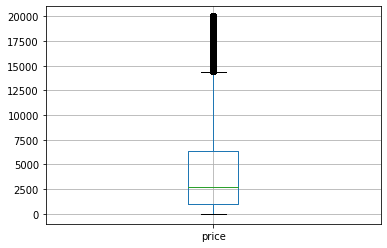

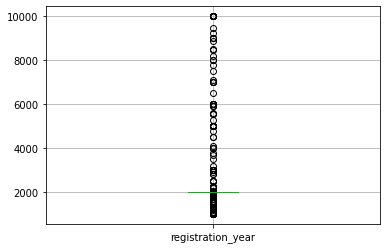

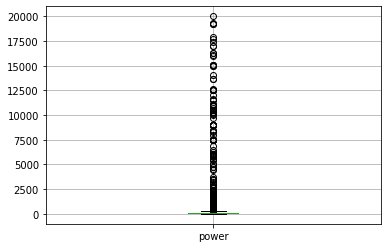

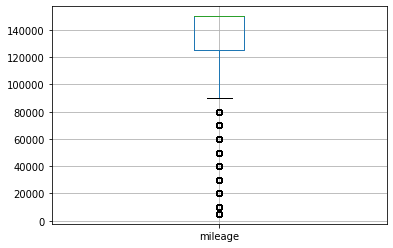

In [28]:
e = 'price', 'registration_year', 'power', 'mileage'
for i in e:
    df.boxplot(i)
    plt.show()

Remoção de dados duplicados: 

In [29]:
df.duplicated().sum()

305

In [30]:
df=df.drop_duplicates()
df.reset_index(drop=True,inplace=True)
df.duplicated().sum()

0

Decidi retirar da amostra todos os veículos de ano de registro menor que 1960 pois são muito antigos e todos com ano de registro após 2017, já que todos as informações de data vão somente até 2016.  

<AxesSubplot:>

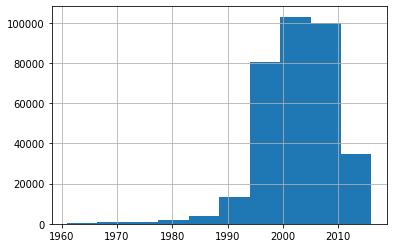

In [31]:
df = df.loc[df['registration_year']<2017]
df = df.loc[df['registration_year']>1960]
df['registration_year'].hist()

Remoção de preços inferiores a 100. Dificilmente um carro custa menos de 100EUR. 

<AxesSubplot:>

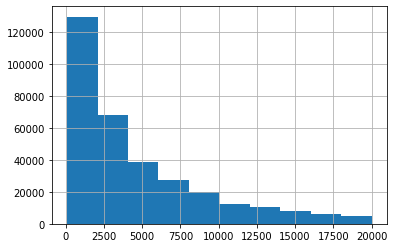

In [32]:
df = df.loc[df['price']>100]

df['price'].hist()

Substituição dos valores anormais de força pela média da marca do veículo. 

<AxesSubplot:>

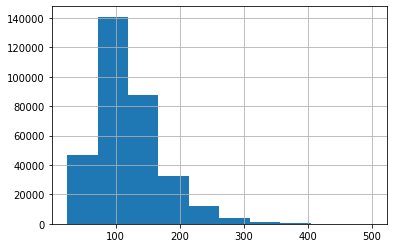

In [33]:
df['power'] = np.where((df['power'] == 0), df.groupby('brand')['power'].transform('mean').round(0), df['power'])
df['power'] = np.where((df['power'] > 500), df.groupby('brand')['power'].transform('mean').round(0), df['power'])
df['power'] = np.where((df['power'] < 50), df.groupby('brand')['power'].transform('mean').round(0), df['power'])
df['power'].hist()

Com as alterações acima, os gráficos boxplot mostraram a redução dos outliers. 

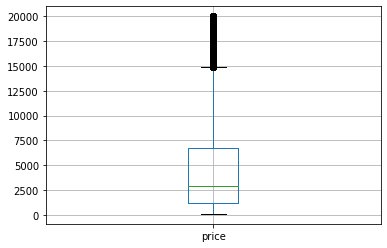

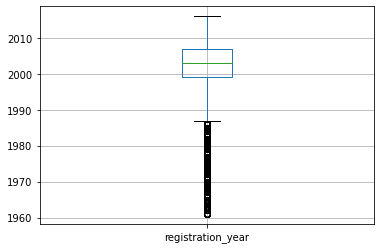

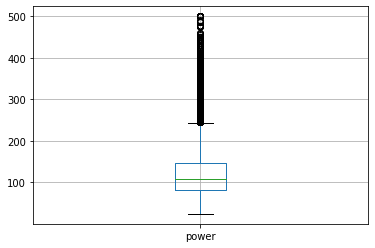

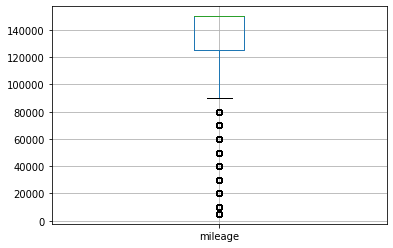

In [34]:
for i in e:
    df.boxplot(i)
    plt.show()

Assim ficou a tabela:

In [35]:
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:00,480,sedan,1993,manual,97.0,golf,150000,0,gasoline,volkswagen,0,2016-03-24,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190.0,other,125000,5,gasoline,audi,1,2016-03-24,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,0,2016-03-14,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75.0,golf,150000,6,gasoline,volkswagen,0,2016-03-17,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,0,2016-03-31,60437,2016-04-06 10:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354058,2016-03-27 20:36:00,1150,bus,2000,manual,94.0,zafira,150000,3,gasoline,opel,0,2016-03-27,26624,2016-03-29 10:17:00
354060,2016-03-14 17:48:00,2200,sedan,2005,manual,115.0,other,20000,1,gasoline,sonstige_autos,0,2016-03-14,39576,2016-04-06 00:46:00
354061,2016-03-05 19:56:00,1199,convertible,2000,auto,101.0,fortwo,125000,3,gasoline,smart,0,2016-03-05,26135,2016-03-11 18:17:00
354062,2016-03-19 18:57:00,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,0,2016-03-19,87439,2016-04-07 07:15:00


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325635 entries, 0 to 354063
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        325635 non-null  datetime64[ns]
 1   price               325635 non-null  int64         
 2   vehicle_type        325635 non-null  object        
 3   registration_year   325635 non-null  int64         
 4   gearbox             325635 non-null  object        
 5   power               325635 non-null  float64       
 6   model               325635 non-null  object        
 7   mileage             325635 non-null  int64         
 8   registration_month  325635 non-null  int64         
 9   fuel_type           325635 non-null  object        
 10  brand               325635 non-null  object        
 11  not_repaired        325635 non-null  int64         
 12  date_created        325635 non-null  datetime64[ns]
 13  postal_code         325635 no

In [37]:
df.describe()

,price,registration_year,power,mileage,registration_month,not_repaired,postal_code
count,325635.000000,325635.000000,325635.000000,325635.000000,325635.000000,325635.000000,325635.000000
mean,4651.856791,2002.699157,120.313421,128430.896556,5.849967,0.098174,50797.010589
std,4543.243452,6.597432,50.977926,37145.049128,3.666604,0.297551,25741.297694
min,101.000000,1961.000000,24.000000,5000.000000,0.000000,0.000000,1067.000000
25%,1249.000000,1999.000000,82.000000,125000.000000,3.000000,0.000000,30459.000000
50%,2950.000000,2003.000000,109.000000,150000.000000,6.000000,0.000000,49635.000000
75%,6700.000000,2007.000000,147.000000,150000.000000,9.000000,0.000000,71334.000000
max,20000.000000,2016.000000,500.000000,150000.000000,12.000000,1.000000,99998.000000


Reparei que aumentou a correlação positiva do preço a força do motor (50% agora) e ano de registro (46% agora). Também cresceu a correlação negativa com a quilometragem do veículo (36% agora). 

In [38]:
df.corr()

,price,registration_year,power,mileage,registration_month,not_repaired,postal_code
price,1.000000,0.463685,0.501951,-0.364837,0.087829,-0.186031,0.071508
registration_year,0.463685,1.000000,0.108690,-0.253416,0.060589,-0.083171,0.032141
power,0.501951,0.108690,1.000000,0.099015,0.047865,-0.041251,0.057343
mileage,-0.364837,-0.253416,0.099015,1.000000,-0.005572,0.071138,-0.010135
registration_month,0.087829,0.060589,0.047865,-0.005572,1.000000,-0.035505,0.008402
not_repaired,-0.186031,-0.083171,-0.041251,0.071138,-0.035505,1.000000,-0.000113
postal_code,0.071508,0.032141,0.057343,-0.010135,0.008402,-0.000113,1.000000


## Treinamento do modelo

Primeiro passo para treinar o modelo foi codificar por rótulos as variáveis categóricas. Decidi classificar por ordem de média de preço de cada variável. Assim, um modelo de carro com média de preço superior ao outro terá um valor maior. Achei que isso ajudaria na formação do modelo de regressão.  

In [39]:
a = np.argsort(df.groupby('vehicle_type').mean()['price'].sort_values())
b = np.argsort(df.groupby('gearbox').mean()['price'].sort_values())
c = np.argsort(df.groupby('model').mean()['price'].sort_values())
d = np.argsort(df.groupby('fuel_type').mean()['price'].sort_values())
e = np.argsort(df.groupby('brand').mean()['price'].sort_values())

In [40]:
merge_df= df.merge(a,on='vehicle_type',how='left')
merge_df2 = merge_df.merge(b,on='gearbox',how='left')
merge_df3 = merge_df2.merge(c,on='model',how='left')
merge_df4 = merge_df3.merge(d,on='fuel_type',how='left')
merge_df5 = merge_df4.merge(e,on='brand',how='left')
df_ord = merge_df5
df_ord


,date_crawled,price_x,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen,price_y,price_x,price_y,price_x,price_y
0,2016-03-24 11:52:00,480,sedan,1993,manual,97.0,golf,150000,0,gasoline,volkswagen,0,2016-03-24,70435,2016-04-07 03:16:00,2,0,110,3,24
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190.0,other,125000,5,gasoline,audi,1,2016-03-24,66954,2016-04-07 01:46:00,5,0,107,3,34
2,2016-03-14 12:52:00,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,0,2016-03-14,90480,2016-04-05 12:47:00,7,1,154,3,36
3,2016-03-17 16:54:00,1500,small,2001,manual,75.0,golf,150000,6,gasoline,volkswagen,0,2016-03-17,91074,2016-03-17 17:40:00,0,0,110,3,24
4,2016-03-31 17:25:00,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,0,2016-03-31,60437,2016-04-06 10:17:00,0,0,108,3,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325630,2016-03-27 20:36:00,1150,bus,2000,manual,94.0,zafira,150000,3,gasoline,opel,0,2016-03-27,26624,2016-03-29 10:17:00,4,0,95,3,7
325631,2016-03-14 17:48:00,2200,sedan,2005,manual,115.0,other,20000,1,gasoline,sonstige_autos,0,2016-03-14,39576,2016-04-06 00:46:00,2,0,107,3,32
325632,2016-03-05 19:56:00,1199,convertible,2000,auto,101.0,fortwo,125000,3,gasoline,smart,0,2016-03-05,26135,2016-03-11 18:17:00,6,1,90,3,12
325633,2016-03-19 18:57:00,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,0,2016-03-19,87439,2016-04-07 07:15:00,4,0,169,3,24


In [41]:
df_ord = df_ord.drop(['vehicle_type','gearbox','model','fuel_type','brand','date_crawled','registration_month','date_created','postal_code','last_seen'], axis =1)
df_ord

,price_x,registration_year,power,mileage,not_repaired,price_y,price_x,price_y,price_x,price_y
0,480,1993,97.0,150000,0,2,0,110,3,24
1,18300,2011,190.0,125000,1,5,0,107,3,34
2,9800,2004,163.0,125000,0,7,1,154,3,36
3,1500,2001,75.0,150000,0,0,0,110,3,24
4,3600,2008,69.0,90000,0,0,0,108,3,30
...,...,...,...,...,...,...,...,...,...,...
325630,1150,2000,94.0,150000,0,4,0,95,3,7
325631,2200,2005,115.0,20000,0,2,0,107,3,32
325632,1199,2000,101.0,125000,0,6,1,90,3,12
325633,9200,1996,102.0,150000,0,4,0,169,3,24


In [42]:
df_ord.columns=['price','registration_year','power','mileage','not_repaired','vehicle_type','gearbox','model','fuel_type','brand']

Aqui está a tabela filtrada que usarei para treinar e testar cada modelo. Decidi retirar algumas colunas que julguei não acrescentar para o estudo. 

In [43]:
df_ord

,price,registration_year,power,mileage,not_repaired,vehicle_type,gearbox,model,fuel_type,brand
0,480,1993,97.0,150000,0,2,0,110,3,24
1,18300,2011,190.0,125000,1,5,0,107,3,34
2,9800,2004,163.0,125000,0,7,1,154,3,36
3,1500,2001,75.0,150000,0,0,0,110,3,24
4,3600,2008,69.0,90000,0,0,0,108,3,30
...,...,...,...,...,...,...,...,...,...,...
325630,1150,2000,94.0,150000,0,4,0,95,3,7
325631,2200,2005,115.0,20000,0,2,0,107,3,32
325632,1199,2000,101.0,125000,0,6,1,90,3,12
325633,9200,1996,102.0,150000,0,4,0,169,3,24


Dividi em target e features.

In [44]:
features = df_ord.drop(['price'], axis=1)
target = df_ord['price']

Dividi em conjunto de treinamento e teste. 

In [45]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, random_state = 12345)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(244226, 9)
(81409, 9)
(244226,)
(81409,)


Padronizei as características através do método de escalabilidade. 

In [46]:
feature_names = ['registration_year','power','mileage','not_repaired','vehicle_type','gearbox','model','fuel_type','brand']

transformer_mas = MaxAbsScaler().fit(df_ord[feature_names].to_numpy())

features_train_scaled = features_train.copy()
features_train_scaled.loc[:, feature_names] = transformer_mas.transform(features_train[feature_names].to_numpy())
features_test_scaled = features_test.copy()
features_test_scaled.loc[:, feature_names] = transformer_mas.transform(features_test[feature_names].to_numpy())

In [47]:
features_train_scaled.sample(5)

,registration_year,power,mileage,not_repaired,vehicle_type,gearbox,model,fuel_type,brand
166202,0.995536,0.218,1.000000,0.0,0.285714,0.0,0.345382,0.6,0.794872
215311,0.994048,0.202,0.833333,0.0,0.000000,0.0,0.156627,0.6,0.692308
108018,0.993056,0.250,1.000000,0.0,0.285714,0.0,0.297189,0.6,0.179487
94275,0.993056,0.202,1.000000,0.0,0.428571,0.0,0.441767,0.6,0.615385
149796,0.994544,0.202,1.000000,0.0,0.857143,0.0,0.297189,0.6,0.179487


Abaixo os treinamentos dos modelos e o tempo que levaram para ser processados: 

Regressão Linear

In [48]:
%%time
start_lr = time.process_time()
model_lr = LinearRegression()
model_lr.fit(features_train_scaled,target_train) 
predictions_test = model_lr.predict(features_test_scaled) 
result_lr = mean_squared_error(target_test, predictions_test)**0.5
end_lr  = time.process_time()
lr_time = round(end_lr-start_lr,2)
print('O REQM do modelo de Regressão Linear é:', result_lr)
print(f'Tempo de processamento para Regressão Linear = {lr_time}')

O REQM do modelo de Regressão Linear é: 2889.370509508445
Tempo de processamento para Regressão Linear = 0.09
CPU times: user 51.8 ms, sys: 39.9 ms, total: 91.7 ms
Wall time: 76.4 ms


In [49]:
%%time
predictions_test = model_lr.predict(features_test_scaled) 
result_lr = mean_squared_error(target_test, predictions_test)**0.5
lr_time = round(end_lr-start_lr,2)
print('O REQM do modelo de Regressão Linear é:', result_lr)


O REQM do modelo de Regressão Linear é: 2889.370509508445
CPU times: user 3.42 ms, sys: 7.98 ms, total: 11.4 ms
Wall time: 4.49 ms


Floresta Aleatória

In [50]:
%%time
model_ranforest = RandomForestRegressor(random_state=12345) 
model_ranforest.fit(features_train_scaled,target_train) 
predictions_test_ranforest = model_ranforest.predict(features_test_scaled) 
result_ranforest = mean_squared_error(target_test, predictions_test_ranforest)**0.5
print('O REQM do modelo de Regressão Floresta Aleatória é:', result_ranforest)

O REQM do modelo de Regressão Floresta Aleatória é: 1612.4156155946187
CPU times: user 1min 16s, sys: 404 ms, total: 1min 16s
Wall time: 1min 16s


In [51]:
%%time

best_model_ranforest = None
best_result_ranforest = 10000
best_est_ranforest = 0
best_depth_ranforest = 0
for est in range(30, 51, 10):
    for depth in range (5, 16, 5):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train_scaled,target_train) 
        predictions_test = model.predict(features_test_scaled) 
        result = mean_squared_error(target_test, predictions_test)**0.5
        if result < best_result_ranforest:
            best_model_ranforest = model
            best_result_ranforest = result
            best_est_ranforest = est
            best_depth_ranforest = depth

print("REQM do melhor modelo de Floresta Aleatória no conjunto de teste é:", best_result_ranforest, ", com n_estimators:", best_est_ranforest, "e profundidade:", best_depth_ranforest)

REQM do melhor modelo de Floresta Aleatória no conjunto de teste é: 1635.70375812869 , com n_estimators: 50 e profundidade: 15
CPU times: user 2min 29s, sys: 59.9 ms, total: 2min 30s
Wall time: 2min 30s


In [52]:
%%time
predictions_test_ranforest = model_ranforest.predict(features_test_scaled) 
result_ranforest = mean_squared_error(target_test, predictions_test_ranforest)**0.5
print('O REQM do modelo de Regressão Floresta Aleatória é:', result_ranforest)

O REQM do modelo de Regressão Floresta Aleatória é: 1612.4156155946187
CPU times: user 3.35 s, sys: 3.96 ms, total: 3.36 s
Wall time: 3.36 s


Árvore de Decisão

In [53]:
%%time
model_tree = DecisionTreeRegressor(random_state=12345) 
model_tree.fit(features_train_scaled,target_train) 
predictions_test_tree = model_tree.predict(features_test_scaled) 
result_tree = mean_squared_error(target_test, predictions_test_tree)**0.5
print('O REQM do modelo de Regressão Árvore de Decisão é:', result_tree)

O REQM do modelo de Regressão Árvore de Decisão é: 1942.6988960065785
CPU times: user 1.13 s, sys: 0 ns, total: 1.13 s
Wall time: 1.14 s


In [54]:
%%time

best_model_tree = None
best_result_tree = 10000
best_depth_tree = 0

for depth in range (5, 16, 5):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
    model.fit(features_train_scaled,target_train) 
    predictions_test = model.predict(features_test_scaled) 
    result = mean_squared_error(target_test, predictions_test)**0.5
    if result < best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth

print("REQM do melhor modelo de Árvore de Decisão no conjunto de teste é:", best_result_tree, "com profundidade ", best_depth_tree)

REQM do melhor modelo de Árvore de Decisão no conjunto de teste é: 1835.1242052817147 com profundidade  15
CPU times: user 1.75 s, sys: 3.95 ms, total: 1.75 s
Wall time: 1.76 s


In [55]:
%%time
predictions_test_tree = best_model_tree.predict(features_test_scaled) 
result_tree_best = mean_squared_error(target_test, predictions_test_tree)**0.5
print('O REQM do melhor modelo de Árvore de Decisão é:', result_tree_best)

O REQM do melhor modelo de Árvore de Decisão é: 1835.1242052817147
CPU times: user 21.2 ms, sys: 7 µs, total: 21.2 ms
Wall time: 19.5 ms


In [56]:
%%time
model = DecisionTreeRegressor(random_state=12345, max_depth=best_depth_tree) 
model.fit(features_train_scaled,target_train) 
predictions_test_tree = model.predict(features_test_scaled) 
result_tree = mean_squared_error(target_test, predictions_test_tree)**0.5
print('O REQM do melhor modelo de Árvore de Decisão é:', result_tree)

O REQM do melhor modelo de Árvore de Decisão é: 1835.1242052817147
CPU times: user 856 ms, sys: 0 ns, total: 856 ms
Wall time: 870 ms


LightGBM

In [57]:
%%time

model = LGBMRegressor()
model.fit(features_train_scaled,target_train)
predictions_test = model.predict(features_test_scaled) 
result_LGBM = mean_squared_error(target_test, predictions_test)**0.5
print('O REQM do modelo de LGBMRegressor é:', result_LGBM)

O REQM do modelo de LGBMRegressor é: 1716.0767139110108
CPU times: user 14.4 s, sys: 69.4 ms, total: 14.4 s
Wall time: 14.5 s


In [58]:

%%time

best_model_LGBM = None
best_result_LGBM = 10000
best_est_LGBM = 0
best_depth_LGBM = 0
for est in range(100, 301, 100):
    for depth in range (5, 16, 5):
        model = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth, learning_rate = 0.1) 
        model.fit(features_train_scaled,target_train) 
        predictions_test = model.predict(features_test_scaled) 
        result = mean_squared_error(target_test, predictions_test)**0.5
        if result < best_result_LGBM:
            best_model_LGBM = model
            best_result_LGBM = result
            best_est_LGBM = est
            best_depth_LGBM = depth

print("REQM do melhor modelo LightGBM Regressor no conjunto de teste", best_result_LGBM, "n_estimators:", best_est_LGBM, "best_depth:", best_depth_LGBM)

REQM do melhor modelo LightGBM Regressor no conjunto de teste 1636.795986936639 n_estimators: 300 best_depth: 15
CPU times: user 3min 24s, sys: 1.16 s, total: 3min 26s
Wall time: 3min 27s


In [59]:
%%time
predictions_test_LGBM = best_model_LGBM.predict(features_test_scaled) 
result_LGBM_best = mean_squared_error(target_test, predictions_test_LGBM)**0.5
print('O REQM do melhor modelo de LightGBM é:', result_LGBM_best)

O REQM do melhor modelo de LightGBM é: 1636.795986936639
CPU times: user 1.95 s, sys: 0 ns, total: 1.95 s
Wall time: 1.92 s


In [60]:
%%time
model = LGBMRegressor(random_state=12345, n_estimators=best_est_LGBM, max_depth=best_depth_LGBM, learning_rate = 0.1) 
model.fit(features_train_scaled,target_train)
predictions_test_LGBM = model.predict(features_test_scaled) 
result_LGBM = mean_squared_error(target_test, predictions_test_LGBM)**0.5
print('O REQM do melhor modelo de LightGBM é:', result_LGBM)

O REQM do melhor modelo de LightGBM é: 1636.795986936639
CPU times: user 33.7 s, sys: 193 ms, total: 33.9 s
Wall time: 34.2 s


CatBoost

In [61]:
%%time

model_catboost = CatBoostRegressor(random_seed=12345)
model_catboost.fit(features_train_scaled, target_train, verbose = 100)
predictions_test = model_catboost.predict(features_test_scaled) 
result_catboost = mean_squared_error(target_test, predictions_test)**0.5
print('O REQM do modelo de CatBoostRegressor é:', result_catboost)

Learning rate set to 0.0976
0:	learn: 4260.0128792	total: 107ms	remaining: 1m 46s
100:	learn: 1796.2870594	total: 4.5s	remaining: 40s
200:	learn: 1725.4689213	total: 8.75s	remaining: 34.8s
300:	learn: 1687.4819015	total: 13.1s	remaining: 30.3s
400:	learn: 1661.2551750	total: 17.4s	remaining: 26s
500:	learn: 1640.6120470	total: 21.7s	remaining: 21.6s
600:	learn: 1623.0641963	total: 26s	remaining: 17.3s
700:	learn: 1608.7169530	total: 30.3s	remaining: 12.9s
800:	learn: 1595.4411912	total: 34.7s	remaining: 8.61s
900:	learn: 1584.1024667	total: 38.9s	remaining: 4.28s
999:	learn: 1574.6035581	total: 43.2s	remaining: 0us
O REQM do modelo de CatBoostRegressor é: 1636.8346508118664
CPU times: user 43.4 s, sys: 57.7 ms, total: 43.4 s
Wall time: 43.7 s


In [62]:

%%time

best_model_catboost = None
best_result_catboost = 10000
best_ite_catboost = 0
best_depth_catboost = 0
for ite in range(100, 201, 50):
    for d in range (5, 16, 5):
        model_catboost = CatBoostRegressor(loss_function='RMSE', random_seed=12345, depth=d,iterations = ite, learning_rate = 0.1) 
        model_catboost.fit(features_train_scaled,target_train, verbose = 100) 
        predictions_test = model_catboost.predict(features_test_scaled) 
        result = mean_squared_error(target_test, predictions_test)**0.5
        if result < best_result_catboost:
            best_model_catboost = model_catboost
            best_result_catboost = result
            best_ite_catboost = ite
            best_depth_catboost = d

print("REQM do melhor modelo CatBoost Regressor no conjunto de teste", best_result_catboost, "iterações:", best_ite_catboost, "best_depth:", best_depth_catboost)

0:	learn: 4265.2395277	total: 43.8ms	remaining: 4.33s
99:	learn: 1834.0423814	total: 4.25s	remaining: 0us
0:	learn: 4214.3757400	total: 131ms	remaining: 13s
99:	learn: 1678.0708338	total: 12.7s	remaining: 0us
0:	learn: 4194.9851141	total: 668ms	remaining: 1m 6s
99:	learn: 1539.4372511	total: 1m 5s	remaining: 0us
0:	learn: 4265.2395277	total: 42.5ms	remaining: 6.33s
100:	learn: 1832.6813720	total: 4.33s	remaining: 2.1s
149:	learn: 1786.9033941	total: 6.41s	remaining: 0us
0:	learn: 4214.3757400	total: 129ms	remaining: 19.2s
100:	learn: 1677.0933581	total: 12.6s	remaining: 6.1s
149:	learn: 1632.1731228	total: 18.6s	remaining: 0us
0:	learn: 4194.9851141	total: 684ms	remaining: 1m 41s
100:	learn: 1537.5727846	total: 1m 4s	remaining: 31.4s
149:	learn: 1478.1129343	total: 1m 36s	remaining: 0us
0:	learn: 4265.2395277	total: 44.9ms	remaining: 8.94s
100:	learn: 1832.6813720	total: 4.21s	remaining: 4.13s
199:	learn: 1758.9686979	total: 8.2s	remaining: 0us
0:	learn: 4214.3757400	total: 125ms	remai

In [63]:
%%time
model_catboost = CatBoostRegressor(loss_function='RMSE', random_seed=12345, depth=best_depth_catboost,iterations = best_ite_catboost, learning_rate = 0.1)
model_catboost.fit(features_train_scaled,target_train, verbose = 100)
predictions_test_catboost = best_model_catboost.predict(features_test_scaled) 
result_catboost_best = mean_squared_error(target_test, predictions_test_catboost)**0.5
print('O REQM do melhor modelo de CatBoost é:', result_catboost_best)

0:	learn: 4194.9851141	total: 632ms	remaining: 2m 5s
100:	learn: 1537.5727846	total: 1m 2s	remaining: 1m
199:	learn: 1435.8965984	total: 2m 3s	remaining: 0us
O REQM do melhor modelo de CatBoost é: 1594.534655787259
CPU times: user 1min 38s, sys: 25.3 s, total: 2min 3s
Wall time: 2min 3s


In [64]:
%%time
predictions_test_catboost = best_model_catboost.predict(features_test_scaled) 
result_catboost_best = mean_squared_error(target_test, predictions_test_catboost)**0.5
print('O REQM do melhor modelo de CatBoost é:', result_catboost_best)


O REQM do melhor modelo de CatBoost é: 1594.534655787259
CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 130 ms


XGBoost

In [65]:
%%time

model = XGBRegressor(objective='reg:squarederror')
model.fit(features_train_scaled,target_train)
predictions_test = model.predict(features_test_scaled) 
result_XGB = mean_squared_error(target_test, predictions_test)**0.5
print('O REQM do modelo de XGBRegressor é:', result_XGB)

O REQM do modelo de XGBRegressor é: 1645.2498728472178
CPU times: user 35.7 s, sys: 69.4 ms, total: 35.8 s
Wall time: 36.2 s


In [66]:
%%time

model_xgb = XGBRegressor(random_state=12345, n_estimators=300, max_depth=10, learning_rate = 0.1) 
model_xgb.fit(features_train_scaled,target_train) 
predictions_test_xgb = model_xgb.predict(features_test_scaled) 
result__xgb = mean_squared_error(target_test, predictions_test_xgb)**0.5
print('O REQM do modelo de XGBRegressor com hiperparâmetros é:', result__xgb)

O REQM do modelo de XGBRegressor com hiperparâmetros é: 1553.4736196330912
CPU times: user 3min 20s, sys: 456 ms, total: 3min 20s
Wall time: 3min 26s


Tentei ajustar os hiper parâmetros, mas o tempo sempre excedia. Por isso, tomei a decisão a tentar os hiper parâmetros  n_estimators=300, max_depth=10, learning_rate = 0.1. 

In [67]:
%%time
predictions_test_xgb = model_xgb.predict(features_test_scaled) 
result__xgb = mean_squared_error(target_test, predictions_test_xgb)**0.5
print('O REQM do modelo de XGBRegressor com hiperparâmetros é:', result__xgb)

O REQM do modelo de XGBRegressor com hiperparâmetros é: 1553.4736196330912
CPU times: user 2.3 s, sys: 5.47 ms, total: 2.31 s
Wall time: 2.31 s


Resumo dos resultados:

In [68]:
REQM =[result_lr,result_tree,result_ranforest,result__xgb,result_catboost_best,result_LGBM]
REQM

[2889.370509508445,
 1835.1242052817147,
 1612.4156155946187,
 1553.4736196330912,
 1594.534655787259,
 1636.795986936639]

In [69]:
modelos = ['Regressão Linear','Árvore de Decisão','Floresta Aleatória','XGBoost','CatBoost','LightGBM']
modelos

['Regressão Linear',
 'Árvore de Decisão',
 'Floresta Aleatória',
 'XGBoost',
 'CatBoost',
 'LightGBM']

In [70]:
resultados = pd.DataFrame( 
    {'Model REQM' : REQM,
    'Tempo Treinamento Modelo' : [0.91, 0.85, 78, 216, 131, 12.1],
    'Tempo para Predição' : [0.01, 0.02, 3.5, 2.3, 0.01, 1.93]}, 
    index = modelos)
resultados

,Model REQM,Tempo Treinamento Modelo,Tempo para Predição
Regressão Linear,2889.370510,0.91,0.01
Árvore de Decisão,1835.124205,0.85,0.02
Floresta Aleatória,1612.415616,78.00,3.50
XGBoost,1553.473620,216.00,2.30
CatBoost,1594.534656,131.00,0.01
LightGBM,1636.795987,12.10,1.93


Após treinar 6 modelos diferentes para predição de preço do app da Rusty Bargain, cheguei a conclusão de que o modelo CatBoost seria uma boa opção para a empresa. Ele tem o segundo REQM mais baixo e apesar do treinamento do modelo ser o segundo mais demorado, levando 131 segundos, ele foi muito rápido na predição, apenas 0,01 segundos. Por isso, depois de treinado, esse modelo seria a melhor escolha. 